
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [2]:
# load libraries
#pip install mlxtend
#pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [3]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [4]:
vars1 = pd.read_csv('vars1.csv')

In [6]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables_new.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables_new.csv size is (96397, 1132)
100
200
300
400
500
600
700
800
900
1000
1100
candidate_variables_new.csv                                  variable     score
10                                  Fraud  1.000000
859   Cardnum_Merchnum_MerchState_total_7  0.681666
56               Cardnum_Merchnum_total_7  0.681142
421              Cardnum_MerchZip_total_7  0.678004
868  Cardnum_Merchnum_MerchState_total_14  0.676028
850   Cardnum_Merchnum_MerchState_total_3  0.675441
47               Cardnum_Merchnum_total_3  0.675147
65              Cardnum_Merchnum_total_14  0.675105
339            Cardnum_MerchState_total_3  0.674228
932     Cardnum_Merchnum_MerchZip_total_7  0.672161
494      Cardnum_MerchDescription_total_7  0.671267
412              Cardnum_MerchZip_total_3  0.671050
348            Cardnum_MerchState_total_7  0.669711
357           Cardnum_MerchState_total_14  0.669067
923     Cardnum_Merchnum_MerchZip_total_3  0.666999
941    Cardnum_Merchnu

In [7]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [9]:
filter_score.head(80).to_csv('top_80.csv')

In [11]:
filter_score.tail(10)

,variable,score
978,Cardnum_Merchnum_count_0_by_90,0.045499
1085,Merch state_count_0_by_60,0.045397
1084,Merch state_count_0_by_30,0.043081
1082,Merch state_count_0_by_7,0.040608
1028,Cardnum_MerchState_count_1_by_7,0.040246
1087,Merch state_count_1_by_3,0.037795
1131,RANDOM,0.029279
1092,Merch state_count_1_by_90,0.027674
681,Merch state_day_since,0.008083
8,Transtype,0.000000


In [12]:
filter_score.shape

(1132, 2)

In [13]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_Merchnum_MerchState_total_7', 'Cardnum_Merchnum_total_7', 'Cardnum_MerchZip_total_7', 'Cardnum_Merchnum_MerchState_total_14', 'Cardnum_Merchnum_MerchState_total_3', 'Cardnum_Merchnum_total_3', 'Cardnum_Merchnum_total_14', 'Cardnum_MerchState_total_3', 'Cardnum_Merchnum_MerchZip_total_7', 'Cardnum_MerchDescription_total_7', 'Cardnum_MerchZip_total_3', 'Cardnum_MerchState_total_7', 'Cardnum_MerchState_total_14', 'Cardnum_Merchnum_MerchZip_total_3', 'Cardnum_Merchnum_MerchZip_total_14', 'Cardnum_MerchDescription_total_14', 'Cardnum_MerchZip_total_14', 'Cardnum_MerchDescription_total_3', 'Cardnum_Merchnum_MerchState_total_30', 'Cardnum_MerchDescription_max_14', 'Cardnum_MerchState_total_1', 'Cardnum_Merchnum_total_30', 'Cardnum_Merchnum_MerchState_total_1', 'Cardnum_Merchnum_total_1', 'Cardnum_MerchDescription_total_30', 'Cardnum_MerchDescription_max_7', 'Cardnum_Merchnum_MerchState_max_14', 'Cardnum_MerchDescription_max_30', 'Cardnum_Merchnum_max_14', 'Cardnum_Merc

In [14]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_Merchnum_MerchState_total_7,Cardnum_Merchnum_total_7,Cardnum_MerchZip_total_7,Cardnum_Merchnum_MerchState_total_14,Cardnum_Merchnum_MerchState_total_3,Cardnum_Merchnum_total_3,Cardnum_Merchnum_total_14,Cardnum_MerchState_total_3,Cardnum_Merchnum_MerchZip_total_7,Cardnum_MerchDescription_total_7,...,Cardnum_MerchDescription_max_1,Cardnum_MerchState_max_1,Cardnum_MerchZip_max_60,Merch description_total_3,Cardnum_Merchnum_MerchZip_max_90,Cardnum_Merchnum_MerchState_max_1,Cardnum_Merchnum_max_1,Cardnum_MerchZip_max_1,Merch state_actual/med_90,Cardnum_MerchZip_max_90
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,1023.04,1023.04,174.20,174.20,1023.04,174.20,1023.04,1023.04,...,174.20,174.20,792.26,3171.85,792.26,174.20,174.20,174.20,1.332517,792.26
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,1.428571,250.00
2997,76.85,76.85,53.88,76.85,76.85,76.85,76.85,76.85,53.88,76.85,...,53.88,53.88,53.88,3116.86,53.88,53.88,53.88,53.88,0.276308,53.88
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,1269.00,1269.00,1269.00,6604.53,1269.00,1269.00,1269.00,1269.00,7.511098,1269.00
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,288.38,288.38,288.38,1645.88,288.38,288.38,288.38,288.38,1.466389,288.38


In [15]:
df_keep.shape

(80983, 80)

In [17]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [18]:
Y = Y.values
Y_save = Y.copy()

In [19]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [20]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:04:25.032398


In [21]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [22]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [23]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [24]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [25]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.6s finished

[2022-04-27 22:40:58] Features: 1/20 -- score: 0.6140203154236834[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   10.5s finished

[2022-04-27 22:41:09] Features: 2/20 -- score: 0.6936514300989041[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   12.0s finished

[2022-04-27 22:41:21] Features: 3/20 -- score: 0.7097433841218926[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  77 o

Wall time: 6min 41s


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   25.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   25.4s finished

[2022-04-27 22:47:25] Features: 20/20 -- score: 0.7167334937182571

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x00000201394CB9D0>,
                          verbose=2)

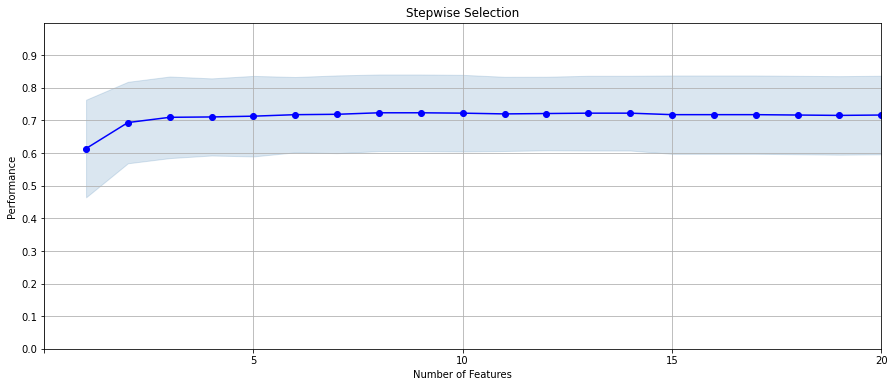

In [27]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [28]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [29]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [30]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(17,)","[0.4482758620689655, 0.5517241379310345, 0.827...",0.61402,"(Cardnum_MerchDescription_total_3,)",0.111122,0.149617,0.049872,1.0,Cardnum_MerchDescription_total_3
2,"(17, 66)","[0.5632183908045977, 0.6551724137931034, 0.712...",0.693651,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.092752,0.124883,0.041628,2.0,Cardnum_MerchState_max_14
3,"(17, 27, 66)","[0.6206896551724138, 0.6551724137931034, 0.781...",0.709743,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.092893,0.125073,0.041691,3.0,Cardnum_MerchDescription_max_30
4,"(17, 27, 66, 67)","[0.632183908045977, 0.6666666666666666, 0.8045...",0.710866,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.087806,0.118223,0.039408,4.0,Cardnum_Merchnum_MerchZip_max_60
5,"(17, 27, 65, 66, 67)","[0.632183908045977, 0.7011494252873564, 0.7471...",0.713232,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.091702,0.123469,0.041156,5.0,Cardnum_MerchZip_total_90
6,"(17, 27, 57, 65, 66, 67)","[0.632183908045977, 0.6781609195402298, 0.7356...",0.717829,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.085746,0.115449,0.038483,6.0,Cardnum_MerchDescription_total_1
7,"(17, 27, 42, 57, 65, 66, 67)","[0.6436781609195402, 0.6551724137931034, 0.735...",0.719006,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.088518,0.119182,0.039727,7.0,Cardnum_Merchnum_MerchZip_max_14
8,"(17, 27, 42, 57, 65, 66, 67, 70)","[0.6206896551724138, 0.7126436781609196, 0.724...",0.72363,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.087199,0.117406,0.039135,8.0,Cardnum_MerchDescription_max_1
9,"(17, 27, 42, 48, 57, 65, 66, 67, 70)","[0.6206896551724138, 0.7126436781609196, 0.724...",0.72363,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.087199,0.117406,0.039135,9.0,Cardnum_Merchnum_MerchZip_max_30
10,"(17, 27, 38, 42, 48, 57, 65, 66, 67, 70)","[0.6206896551724138, 0.7126436781609196, 0.712...",0.722481,"(Cardnum_MerchDescription_total_3, Cardnum_Mer...",0.087233,0.117451,0.03915,10.0,Cardnum_MerchZip_max_14


In [31]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [32]:
ordered_vars_FS['variable name']

1      Cardnum_MerchDescription_total_3
2             Cardnum_MerchState_max_14
3       Cardnum_MerchDescription_max_30
4      Cardnum_Merchnum_MerchZip_max_60
5             Cardnum_MerchZip_total_90
6      Cardnum_MerchDescription_total_1
7      Cardnum_Merchnum_MerchZip_max_14
8        Cardnum_MerchDescription_max_1
9      Cardnum_Merchnum_MerchZip_max_30
10              Cardnum_MerchZip_max_14
11       Cardnum_MerchDescription_max_3
12               Cardnum_Merchnum_max_1
13               Cardnum_MerchZip_max_3
14      Cardnum_Merchnum_MerchZip_max_3
15             Cardnum_MerchState_max_1
16    Cardnum_Merchnum_MerchState_max_1
17               Cardnum_MerchZip_max_1
18              Cardnum_Merchnum_max_14
19       Cardnum_MerchDescription_max_7
20    Cardnum_Merchnum_MerchState_max_7
Name: variable name, dtype: object

In [33]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [34]:
vars_keep

1      Cardnum_MerchDescription_total_3
2             Cardnum_MerchState_max_14
3       Cardnum_MerchDescription_max_30
4      Cardnum_Merchnum_MerchZip_max_60
5             Cardnum_MerchZip_total_90
6      Cardnum_MerchDescription_total_1
7      Cardnum_Merchnum_MerchZip_max_14
8        Cardnum_MerchDescription_max_1
9      Cardnum_Merchnum_MerchZip_max_30
10              Cardnum_MerchZip_max_14
11       Cardnum_MerchDescription_max_3
12               Cardnum_Merchnum_max_1
13               Cardnum_MerchZip_max_3
14      Cardnum_Merchnum_MerchZip_max_3
15             Cardnum_MerchState_max_1
16    Cardnum_Merchnum_MerchState_max_1
17               Cardnum_MerchZip_max_1
18              Cardnum_Merchnum_max_14
19       Cardnum_MerchDescription_max_7
20    Cardnum_Merchnum_MerchState_max_7
Name: variable name, dtype: object

In [35]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_MerchDescription_total_3',
 'Cardnum_MerchState_max_14',
 'Cardnum_MerchDescription_max_30',
 'Cardnum_Merchnum_MerchZip_max_60',
 'Cardnum_MerchZip_total_90',
 'Cardnum_MerchDescription_total_1',
 'Cardnum_Merchnum_MerchZip_max_14',
 'Cardnum_MerchDescription_max_1',
 'Cardnum_Merchnum_MerchZip_max_30',
 'Cardnum_MerchZip_max_14',
 'Cardnum_MerchDescription_max_3',
 'Cardnum_Merchnum_max_1',
 'Cardnum_MerchZip_max_3',
 'Cardnum_Merchnum_MerchZip_max_3',
 'Cardnum_MerchState_max_1',
 'Cardnum_Merchnum_MerchState_max_1',
 'Cardnum_MerchZip_max_1',
 'Cardnum_Merchnum_max_14',
 'Cardnum_MerchDescription_max_7',
 'Cardnum_Merchnum_MerchState_max_7',
 'Recnum',
 'Fraud']

In [36]:
df = pd.read_csv(file_name)

In [37]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [38]:
df_keep.to_csv('vars_final.csv',index=False)

In [39]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:12:36.150089
